# 📰 News Article Recommender System
**Author:** Swati Nain  
**Date:** July 2025  

> A content-based news article recommendation system using NLP and cosine similarity.


In [7]:
import pandas as pd

# Load the dataset
file_path = r"C:\Users\swati nain\Downloads\archive (1)\News_Category_Dataset_v3.json"
df = pd.read_json(file_path, lines=True)

# Keep only necessary columns
df = df[['headline', 'short_description', 'category']]
df.dropna(inplace=True)

# Combine headline and short description into one text column
df['text'] = df['headline'] + " " + df['short_description']

# Preview the data
df.head()


,headline,short_description,category,text
0,Over 4 Million Americans Roll Up Sleeves For O...,Health experts said it is too early to predict...,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,"American Airlines Flyer Charged, Banned For Li...",He was subdued by passengers and crew when he ...,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,23 Of The Funniest Tweets About Cats And Dogs ...,"""Until you have a dog you don't understand wha...",COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...
3,The Funniest Tweets From Parents This Week (Se...,"""Accidentally put grown-up toothpaste on my to...",PARENTING,The Funniest Tweets From Parents This Week (Se...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,Amy Cooper accused investment firm Franklin Te...,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...


In [9]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove stopwords and lemmatize
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

# Apply cleaning
df['clean_text'] = df['text'].apply(clean_text)

# Check the cleaned text
df[['text', 'clean_text']].head()


[nltk_data] Downloading package stopwords to C:\Users\swati
[nltk_data]     nain\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to C:\Users\swati
[nltk_data]     nain\AppData\Roaming\nltk_data...


,text,clean_text
0,Over 4 Million Americans Roll Up Sleeves For O...,million american roll sleeve omicrontargeted c...
1,"American Airlines Flyer Charged, Banned For Li...",american airline flyer charged banned life pun...
2,23 Of The Funniest Tweets About Cats And Dogs ...,funniest tweet cat dog week sept dog dont unde...
3,The Funniest Tweets From Parents This Week (Se...,funniest tweet parent week sept accidentally p...
4,Woman Who Called Cops On Black Bird-Watcher Lo...,woman called cop black birdwatcher loses lawsu...


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)

# Fit and transform the clean text
tfidf_matrix = tfidf.fit_transform(df['clean_text'])

# Shape of the resulting matrix
print("TF-IDF matrix shape:", tfidf_matrix.shape)


TF-IDF matrix shape: (209527, 99750)


In [15]:
from sklearn.neighbors import NearestNeighbors

# Fit NearestNeighbors model (we use cosine distance, so set metric='cosine')
nn_model = NearestNeighbors(metric='cosine', algorithm='brute')
nn_model.fit(tfidf_matrix)

print("NearestNeighbors model fitted.")


NearestNeighbors model fitted.


In [21]:

def get_recommendations(title, df, model, tfidf_matrix, n_recommendations=5):
    matches = df[df['headline'].str.strip().str.lower() == title.strip().lower()]
    
    if matches.empty:
        print(f"❌ Headline not found: {title}")
        return
    
    idx = matches.index[0]
    distances, indices = model.kneighbors(tfidf_matrix[idx], n_neighbors=n_recommendations+1)
    
    print(f"\n📌 Top Recommendations for: {df['headline'].iloc[idx]}\n")
    for i in range(1, len(distances[0])):
        print(f"{i}. {df['headline'].iloc[indices[0][i]]}  (Similarity Score: {1 - distances[0][i]:.2f})")


In [23]:
df['headline'].sample(10).tolist()



["Paul Ryan: Greg Gianforte 'Should Apologize' For 'Body-Slamming' Reporter",
 'Record 1 Billion People Used Facebook In A Single Day',
 "Don't Drive Yourself Crazy! Here are 5 Ways to Drive Yourself Happy -- Every Day",
 'Fork-In-The-Road Pad Thai',
 "Carl Bernstein: 'Today Was A Great Day For The Truth'",
 "Budget Airlines' New Routes Lead To Urbanization In Asia",
 'Schatz And Hanabusa Face More Major Disagreements During TV Debate',
 "This Is Exactly What's Wrong With Raising Baby Animals In Captivity",
 'Trump Deploys More Troops To Middle East After U.S. Embassy Attack',
 'This New Technology May Hold Clues To Stopping Viruses']

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(title, df, tfidf_matrix, n_recommendations=5):
    # Get the index of the article that matches the title
    idx = df[df['headline'] == title].index

    if len(idx) == 0:
        print("Title not found.")
        return

    idx = idx[0]

    # Compute the cosine similarity between this article and all others
    cosine_similarities = cosine_similarity(tfidf_matrix[idx], tfidf_matrix).flatten()

    # Get the indices of the top N similar articles (excluding the selected one)
    similar_indices = cosine_similarities.argsort()[::-1][1:n_recommendations+1]

    # Return the recommended articles
    print(f"\n📌 **Top {n_recommendations} similar articles to:**\n▶️ {title}\n")
    for i, index in enumerate(similar_indices):
        print(f"{i+1}. {df.iloc[index]['headline']}")



In [31]:
get_recommendations(
    title="Record 1 Billion People Used Facebook In A Single Day",
    df=df,
    tfidf_matrix=tfidf_matrix,
    n_recommendations=5
)



📌 **Top 5 similar articles to:**
▶️ Record 1 Billion People Used Facebook In A Single Day

1. Facebook Profit Soars, Stock Hits All-Time High
2. Drag Queen's Drop From Top Of Double-Decker Bus Into The Splits Has To Be Seen To Be Believed
3. No Wow Ever Came About Because You Said 'No'
4. 8 Ways Singles Pay More on Tax Day -- And Every Other Day, Too
5. The Reason Why We Meditate: Wow!


C:\Users\swati nain\AppData\Local\Temp\ipykernel_17044\2920729031.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='category', order=df['category'].value_counts().index[:15], palette='viridis')


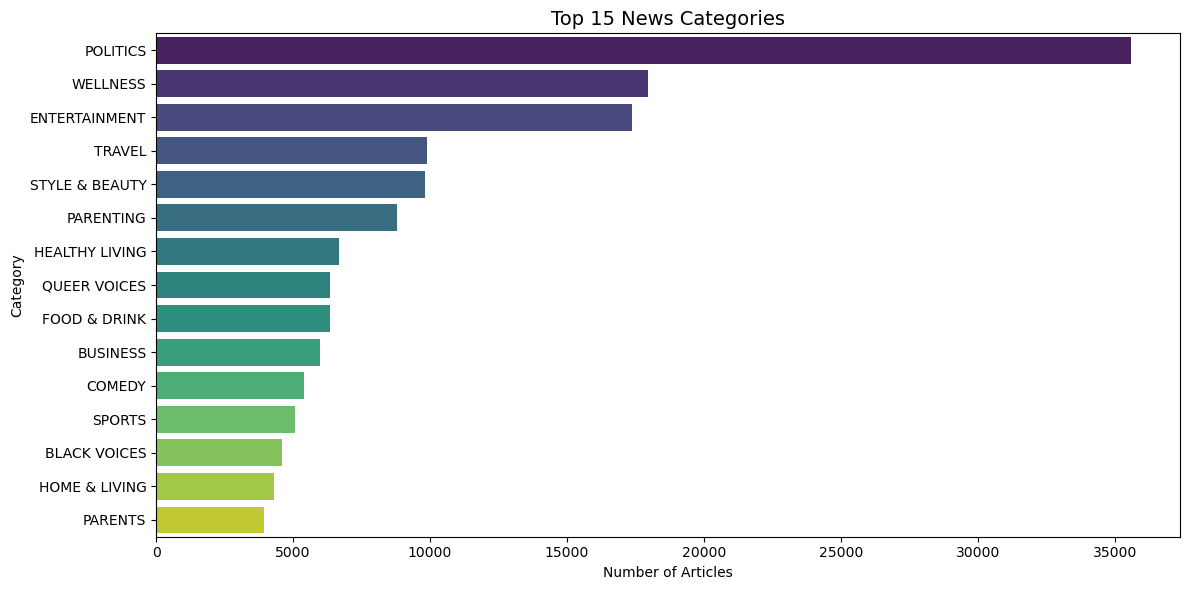

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting top 15 categories by frequency
plt.figure(figsize=(12, 6))
sns.countplot(data=df, y='category', order=df['category'].value_counts().index[:15], palette='viridis')

# Chart styling
plt.title('Top 15 News Categories', fontsize=14)
plt.xlabel('Number of Articles')
plt.ylabel('Category')
plt.tight_layout()

# Display the chart
plt.show()


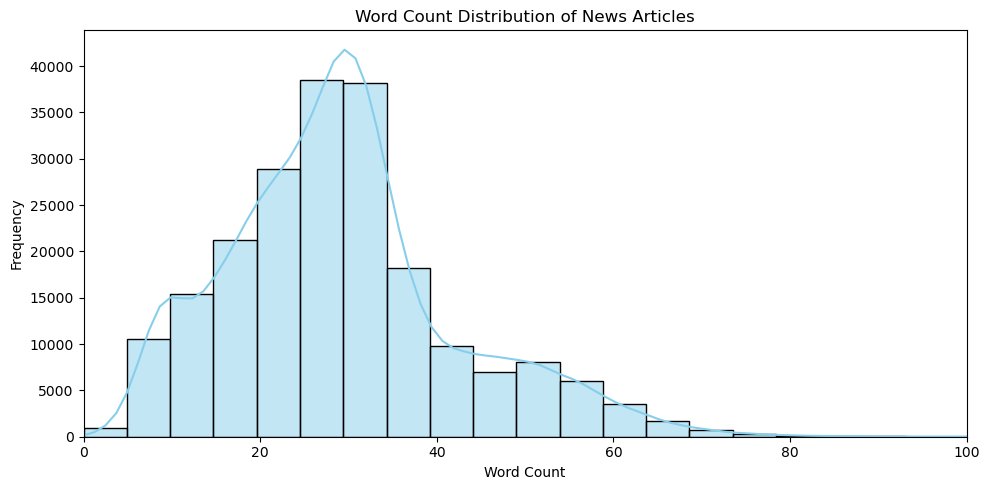

In [35]:
# Add a new column for word count
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

# Plotting histogram
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=50, kde=True, color='skyblue')

# Chart styling
plt.title('Word Count Distribution of News Articles')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # You can increase this if you want to see beyond 100 words
plt.tight_layout()

# Show the plot
plt.show()


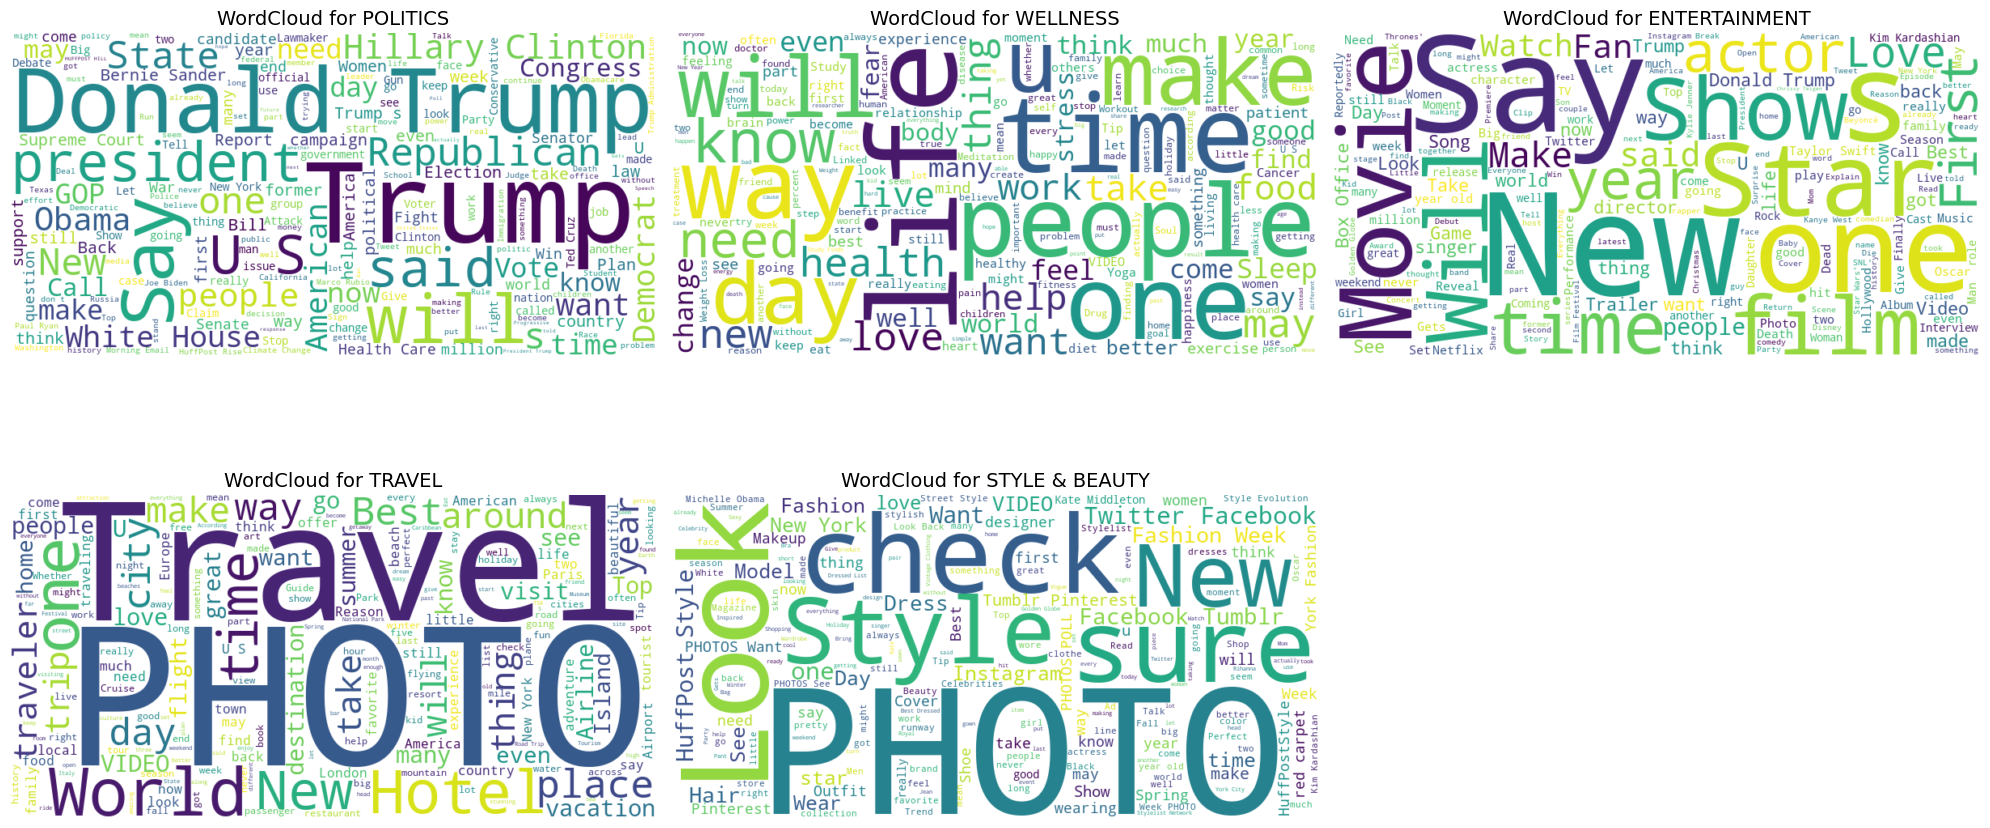

In [37]:
from wordcloud import WordCloud
from collections import Counter

# Check top 5 most common categories
top_categories = df['category'].value_counts().nlargest(5).index.tolist()

# Create word clouds for each of these top categories
plt.figure(figsize=(20, 10))

for i, category in enumerate(top_categories):
    text = ' '.join(df[df['category'] == category]['text'].astype(str).values)
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)

    plt.subplot(2, 3, i+1)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {category}", fontsize=14)

plt.tight_layout()
plt.show()


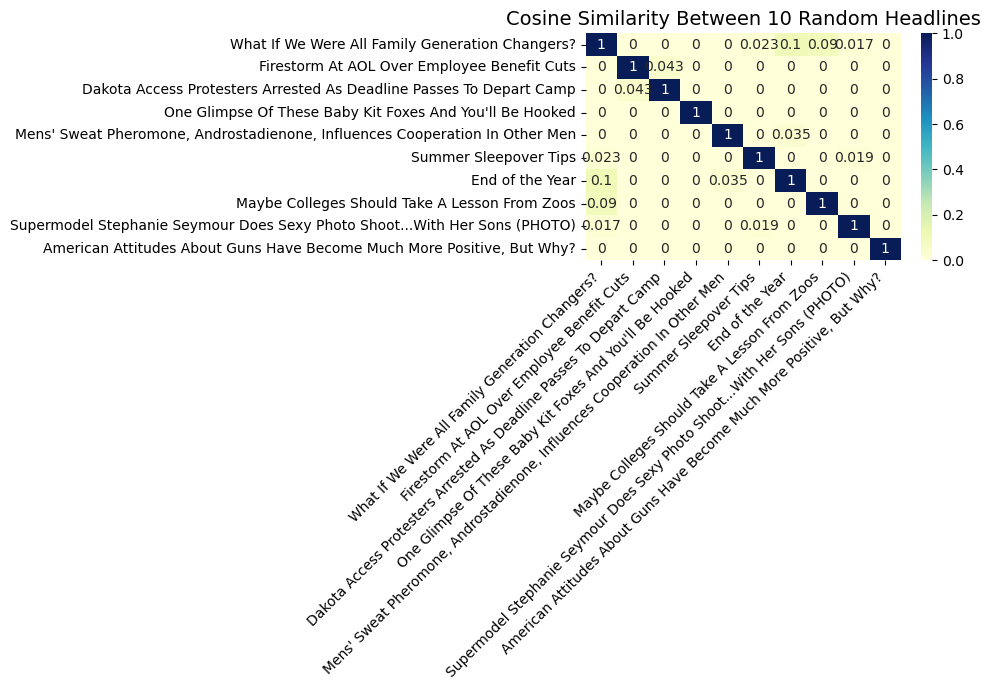

In [39]:
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Sample 10 articles and get their TF-IDF vectors
sample_df = df.sample(10, random_state=42)
sample_vectors = tfidf_matrix[sample_df.index]

# Compute cosine similarity
cosine_sim_sample = cosine_similarity(sample_vectors)

# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cosine_sim_sample, annot=True, cmap='YlGnBu', xticklabels=sample_df['headline'], yticklabels=sample_df['headline'])
plt.title("Cosine Similarity Between 10 Random Headlines", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


## Project Summary

This project showcases a Content-Based News Article Recommender System using Natural Language Processing (NLP) techniques such as TF-IDF and Cosine Similarity.

Key Features:
- Dataset: 200K+ articles from HuffPost
- Text cleaning, tokenization, and lemmatization using nltk
- Visualized most common categories and word frequencies
- Built a TF-IDF matrix of all articles
- Retrieved top 5 most similar headlines based on content
- Heatmap visualization of cosine similarity for article clusters

Technologies Used:
- Python, Pandas, NumPy, Matplotlib, Seaborn
- Scikit-learn (TF-IDF, cosine similarity)
- NLTK for text preprocessing
- WordCloud for text visualization

Author: Swati Nain  
Date: July 2025  
Purpose: For portfolio, resume, and GitHub showcasing of NLP skills.
